<a href="https://colab.research.google.com/github/williamedwardhahn/HyperMap/blob/main/Image_2_SVG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-7-a60f7bdb07fe>:107: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scaled_image = np.asarray(255 * scaled_image, dtype=np.int)
<ipython-input-7-a60f7bdb07fe>:40: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 

SVG Process:
	Origin image size: (1024, 1024)
	Number of base colors: 11
	Number of polygons: 258
	Consume time: 9.33 s


<ipython-input-7-a60f7bdb07fe>:107: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scaled_image = np.asarray(255 * scaled_image, dtype=np.int)
<ipython-input-7-a60f7bdb07fe>:40: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 

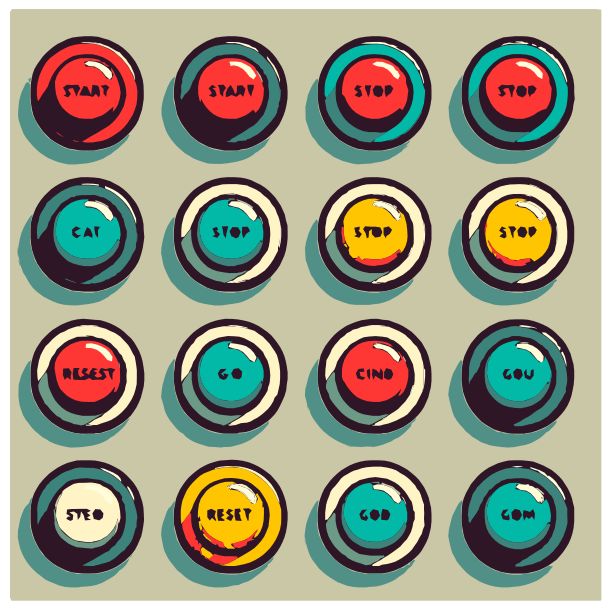

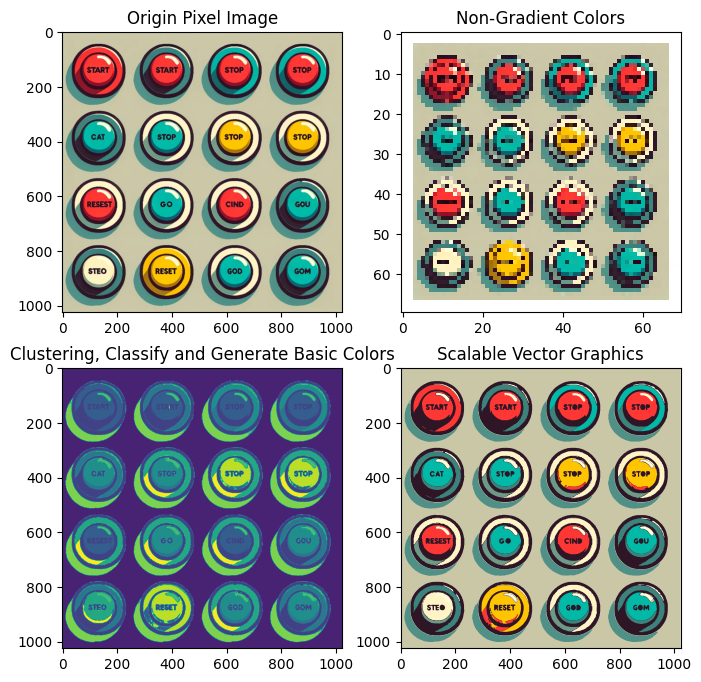

In [7]:
import time

import numpy as np
from sklearn.cluster import DBSCAN
from skimage import transform, measure, io
from scipy.interpolate import interp1d, CubicSpline

import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection


def polygon_area(vertices):
    x, y = vertices[:, 0], vertices[:, 1]
    return 0.5 * (np.dot(x, np.roll(y, -1)) - np.dot(x, np.roll(y, 1)))


def polygon_perimeter(vertices):
    return np.sum(np.linalg.norm(vertices[1:] - vertices[:-1], axis=-1))


def interpolate(vertices):
    perimeter = polygon_perimeter(vertices)
    std_t = np.linspace(0, 1, num=int(perimeter), endpoint=True)

    t = np.linspace(0, 1, num=vertices.__len__(), endpoint=True)
    x = interp1d(t, vertices[:, 0])(std_t)
    y = interp1d(t, vertices[:, 1])(std_t)
    return np.stack([x, y], axis=1)


def smooth(vertices, box_pts):
    # setting convolution window.
    if box_pts % 2 == 0:
        box = np.hstack([np.arange(1, box_pts // 2 + 1), np.arange(box_pts // 2, 0, -1)])
    else:
        box = np.hstack([np.arange(1, box_pts // 2 + 1), np.arange(box_pts // 2 + 1, 0, -1)])
    box = box / np.sum(box)

    # padding the vector into 'SAME' mode.
    vertices = np.asarray(vertices, np.float)
    pad = box_pts // 2 + 1
    x = np.hstack([vertices[-pad:, 0], vertices[:, 0], vertices[:pad, 0]])
    y = np.hstack([vertices[-pad:, 1], vertices[:, 1], vertices[:pad, 1]])

    # smooth the curve
    x_smooth = np.convolve(x, box, mode="same")[pad:-pad]
    y_smooth = np.convolve(y, box, mode="same")[pad:-pad]
    return np.stack([x_smooth, y_smooth], axis=1)


def tangent(vertices):
    if polygon_area(vertices) > 0:
        x, y = vertices[:, 0], vertices[:, 1]
    else:
        x, y = vertices[::-1, 0], vertices[::-1, 1]

    t = np.linspace(0, 1, num=x.__len__())

    cx = CubicSpline(t, x)
    cy = CubicSpline(t, y)

    pt = 0.1 * np.roll(t, 1) + 0.9 * t
    nt = 0.1 * np.roll(t, -1) + 0.9 * t

    dx = (cx(pt) - cx(nt)) / x.__len__()
    dy = (cy(pt) - cy(nt)) / x.__len__()

    norm = np.sqrt(np.square(dx) + np.square(dy))
    return np.stack([dx / norm, dy / norm], axis=-1)


def normal(vertices):
    vectors = tangent(vertices)
    return np.stack([vectors[:, 1], -vectors[:, 0]], axis=-1)



def image_read(file_path_or_url):
    image = io.imread(file_path_or_url)
    if image.shape.__len__() == 2:
        image = np.stack([image] * 3, axis=2)
    if image.shape.__len__() == 3 and image.shape[-1] == 4:
        image = image[:, :, :-1] * np.expand_dims(image[:, :, -1] != 0, axis=2)

    if np.max(image) <= 1:
        image = np.asarray(image * 255, dtype=np.int)

    return image




def generate_polygons(
        image,  # tensor in shape [height, width, 3] and the range of value is [0, 255].
        eps=4, min_samples=16,  # arguments for color classify.
        smooth_length=5, normal_length=2,  # arguments for position classify.
):
    # Pad the image
    pad = np.max(image.shape) // 20
    image = [np.pad(image[:, :, i], (pad, pad), 'constant', constant_values=(255, 255)) for i in range(3)]
    image = np.stack(image, axis=2)

    # Resizing image to adapt limited memory environment.
    height = image.shape[0] // min_samples
    width = image.shape[1] // min_samples
    scaled_image = transform.resize(image, [height, width], anti_aliasing=False)
    scaled_image = np.asarray(255 * scaled_image, dtype=np.int)

    # Compute color base by cluster.
    scatter = np.reshape(scaled_image, [-1, 3])
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(scatter)
    n_cls = np.max(db.labels_) + 1
    base_colors = [np.mean(scatter[[i for i, label in enumerate(db.labels_) if label == cls]], axis=0)
                   for cls in range(n_cls)]  # contain edge colors.
    base_colors = np.array(base_colors)

    # Merge color base of all the unsure pixels to certain color base.
    gaps = np.reshape(image, [1, *image.shape]) - np.reshape(base_colors, [-1, 1, 1, 3])
    arg_min = np.argmin(np.linalg.norm(gaps, axis=-1), axis=0)

    # Compute unsafe contours, some items in it may be similar to each other.
    contours = []
    colors = []
    for i in range(base_colors.__len__()):
        polygons = measure.find_contours(arg_min == i, 0.5)

        for vertices in polygons:
            # Remove noise
            if polygon_perimeter(vertices) < 2 * min_samples:
                continue
            if polygon_perimeter(vertices) / abs(polygon_area(vertices)) > 1.9:
                continue

            # Reduce memory
            vertices = interpolate(vertices)
            # Smooth all polygon.
            vertices = smooth(vertices, box_pts=smooth_length)

            # Add valid polygon into collection
            for anchor, vector in zip(vertices, normal(vertices)):
                point = np.array(anchor - normal_length * vector, dtype=np.int)
                if measure.points_in_poly(points=[point], verts=vertices)[0]:
                    if arg_min[point[0], point[1]] == i:
                        contours.append(vertices)
                        colors.append(base_colors[i, :] / 255)
                        break

    # Analyze embedding order
    graph = np.zeros(shape=(contours.__len__(), contours.__len__()), dtype=np.int)
    for i, vertices in enumerate(contours):
        for j, points in enumerate(contours):
            if i == j:
                continue
            stride = points.__len__() // min_samples
            masks = measure.points_in_poly(points=points[::stride], verts=vertices)
            if 2 * sum(masks) > masks.__len__():
                graph[i, j] = 1
    arg_sort = np.argsort(np.sum(graph, axis=-1))[::-1]
    contours = [contours[index] for index in arg_sort]
    colors = [colors[index] for index in arg_sort]

    # Cancel pad
    contours = [curve - np.array([[pad, pad]]) for curve in contours]

    # return fixed pixel images and svg elements.
    rgb_image = np.array(base_colors[arg_min, :], dtype=np.int)[pad:-pad, pad:-pad]
    gray_image = np.array(arg_min / base_colors.__len__() * 255, dtype=np.int)[pad:-pad, pad:-pad]
    return scaled_image, gray_image, n_cls, contours, colors


def convert_to_svg(pixel_path, svg_path, compress_rate=None):
    start_time = time.time()

    image = image_read(pixel_path)
    _, _, n_cls, contours, colors = generate_polygons(image=image)
    if compress_rate is not None:
        contours = [contour[::compress_rate] for contour in contours]

    _, ax = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
    ax.set_xlim(0, image.shape[1])
    ax.set_ylim(0, image.shape[0])
    ax.invert_yaxis()
    ax.set_axis_off()
    ax.set_aspect('equal', adjustable='box')

    polys = PolyCollection([line[:, ::-1] for line in contours], facecolors=colors)
    ax.add_collection(polys)

    plt.savefig(svg_path, format="svg", bbox_inches='tight', pad_inches=0)

    text = "SVG Process:\n"
    text += "\tOrigin image size: {}\n".format(image.shape[:2])
    text += "\tNumber of base colors: {}\n".format(n_cls)
    text += "\tNumber of polygons: {}\n".format(contours.__len__())
    text += "\tConsume time: {:.2f} s".format(time.time() - start_time)
    print(text)
    return text




if __name__ == "__main__":
    # Demo for convert pixel to svg from URL
    convert_to_svg("buttons2.png", "img.svg", compress_rate=10)

    image_url = "buttons2.png"  # Replace this with your image URL
    img = image_read(image_url)




    scaled_img, gray_img, _, contours_, colors_ = generate_polygons(img)
    fig = plt.figure(figsize=(8, 8))
    ax1 = fig.add_subplot(221)
    ax1.set_title("Origin Pixel Image")
    ax1.imshow(img)
    ax2 = fig.add_subplot(222)
    ax2.set_title("Non-Gradient Colors")
    ax2.imshow(scaled_img)
    ax3 = fig.add_subplot(223)
    ax3.set_title("Clustering, Classify and Generate Basic Colors")
    ax3.imshow(gray_img)
    ax4 = fig.add_subplot(224)
    ax4.set_title("Scalable Vector Graphics")
    ax4.imshow(np.ones_like(img) * 255)
    poly = PolyCollection([line[:, ::-1] for line in contours_], facecolors=colors_)
    ax4.add_collection(poly)
    plt.show()

